### List top 100 nieghbors for each target concept for each year

In [3]:
import json
import csv
from gensim.models import Word2Vec

model_folder = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi_raw/models/'
concepts_file = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/0_data/wordlist/concepts.json'
output_csv = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/topn-by-year.csv'

with open(concepts_file, 'r') as file:
    concepts = json.load(file)

# Create an empty dictionary to store the results
results = {}

# Iterate over each year
for year in range(1979, 2024):

    # Create an empty list to store the word neighbors for each concept
    year_results = []

    # Load the word2vec model
    model = Word2Vec.load(model_folder + f'pd_{year}.model')
    
    # Iterate over each target concept
    for key, value in concepts.items():
        concept = value[0]

        # Check if the concept is present in the word2vec model's vocabulary
        if concept in model.wv.key_to_index:
            # Find the 50 most similar word neighbors for the concept
            neighbors = model.wv.most_similar(concept, topn=100)
            
            # Extract just the words from the word neighbors
            words = [word for word, _ in neighbors]
            
            # Append the list of words to the year_results list
            year_results.append(words)
        else:
            # If the concept is not present, append an empty list to year_results
            year_results.append([])
    
    # Add the year_results list to the results dictionary with the year as the key
    results[str(year)] = year_results
    print(f'{year} done')

with open(output_csv, 'w', newline='') as file:
    writer = csv.writer(file)
    
    # Write the column headers
    writer.writerow(['Year'] + list(concepts.keys()))
    
    # Write the data rows
    for year, year_results in results.items():
        writer.writerow([year] + year_results)

1979 done
1980 done
1981 done
1982 done
1983 done
1984 done
1985 done
1986 done
1987 done
1988 done
1989 done
1990 done
1991 done
1992 done
1993 done
1994 done
1995 done
1996 done
1997 done
1998 done
1999 done
2000 done
2001 done
2002 done
2003 done
2004 done
2005 done
2006 done
2007 done
2008 done
2009 done
2010 done
2011 done
2012 done
2013 done
2014 done
2015 done
2016 done
2017 done
2018 done
2019 done
2020 done
2021 done
2022 done
2023 done


### Store the word neighbors into a JSON dictionary

In [4]:
import pandas as pd
import json

csv_file = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/topn-by-year.csv'

# Read the CSV file
df = pd.read_csv(csv_file)

# Get the target concepts
target_concepts = df.columns[1:].tolist()

word_neighbors_dict = {}

for concept in target_concepts:
    word_neighbors = df[concept].apply(eval).tolist()  # Convert the string representation of a list to an actual list
    word_neighbors = list(set([word for sublist in word_neighbors for word in sublist]))
    word_neighbors_dict[concept] = word_neighbors

# Save the JSON dictionary to a file
json_file = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/all-n.json'
with open(json_file, 'w', encoding='utf-8') as file:
    json.dump(word_neighbors_dict, file, ensure_ascii=False)

### Compute Pearson R and b

In [8]:
import pandas as pd
import statsmodels.api as sm
import scipy.stats as stats

# Load the CSV file containing the similarity scores
concept = input('Enter the concept:')
csv_file = f'/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/{concept}_cos-sim.csv'
df = pd.read_csv(csv_file)

# Compute unstandardized regression coefficients (b) with the year
positive_bs = []
negative_bs = []
valid_cases = {}
for neighbor in df.columns[1:]:
    # Exclude NaN values before calculating the regression
    valid_data = df.dropna(subset=[neighbor, 'Year'])
    if len(valid_data) >= 2:
        X = sm.add_constant(valid_data['Year'])
        y = valid_data[neighbor]
        model = sm.OLS(y, X)
        results = model.fit()
        b = results.params[1]
        p_value = results.pvalues[1]
        correlation, correlation_pvalue = stats.pearsonr(valid_data['Year'], valid_data[neighbor])
        if b >= 0:
            positive_bs.append((neighbor, b, p_value, correlation, correlation_pvalue))
        else:
            negative_bs.append((neighbor, b, p_value, correlation, correlation_pvalue))
        valid_cases[neighbor] = len(valid_data)

# Sort the positive and negative betas separately
positive_bs = sorted(positive_bs, key=lambda x: x[1], reverse=True)
negative_bs = sorted(negative_bs, key=lambda x: x[1], reverse=True)

# Filter neighbors with at least 10 valid cases and significant correlation p-value
filtered_positive_bs = [(n, b, p, c, cp) for n, b, p, c, cp in positive_bs if valid_cases[n] >= 10 and cp < 0.05]
filtered_negative_bs = [(n, b, p, c, cp) for n, b, p, c, cp in negative_bs if valid_cases[n] >= 10 and cp < 0.05]

# Calculate mean cosine similarity across the years
mean_similarity = []
for neighbor in df.columns[1:]:
    mean_sim = df[neighbor].mean()
    std_sim = df[neighbor].std()
    if neighbor in valid_cases and valid_cases[neighbor] >= 30:
        mean_similarity.append((neighbor, mean_sim, std_sim))

# Sort the mean similarity in descending order
mean_similarity = sorted(mean_similarity, key=lambda x: x[1], reverse=True)

# Save the result to a text file
output_file = f'/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/{concept}_regression_coefficients.txt'
with open(output_file, 'w') as file:
    file.write(f'Total number of word neighbors: {len(df.columns) - 1}\n')
    file.write(f'\nFive neighbors with the highest mean cosine similarity across the years:\n')
    for neighbor, mean_sim, std_sim in mean_similarity[:5]:
        file.write(f'Neighbor: {neighbor}; Mean Similarity: {mean_sim}; Standard Deviation: {std_sim}; Valid Cases: {valid_cases[neighbor]}\n')

    file.write(f'\nTen largest positive unstandardized regression coefficients for concept {concept}:\n')
    for neighbor, b, p_value, correlation, correlation_pvalue in filtered_positive_bs[:10]:
        file.write(f'Neighbor: {neighbor}; Valid Cases: {valid_cases[neighbor]}; B: {b}; P-value: {p_value}; Correlation: {correlation}; P-value: {correlation_pvalue} \n')

    file.write(f'\nTen largest negative unstandardized regression coefficients for concept {concept}:\n')
    for neighbor, b, p_value, correlation, correlation_pvalue in filtered_negative_bs[:10]:
        file.write(f'Neighbor: {neighbor}; Valid Cases: {valid_cases[neighbor]}; B: {b};  P-value: {p_value}; Correlation: {correlation}; P-value: {correlation_pvalue} \n')

print(f'The result has been saved to {output_file}.')

/var/folders/n_/yhmj9ckd6f7gps3lsb2bw89w0000gn/T/ipykernel_2325/398449755.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = results.params[1]
/var/folders/n_/yhmj9ckd6f7gps3lsb2bw89w0000gn/T/ipykernel_2325/398449755.py:23: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  p_value = results.pvalues[1]
/var/folders/n_/yhmj9ckd6f7gps3lsb2bw89w0000gn/T/ipykernel_2325/398449755.py:22: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b = 

The result has been saved to /Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/terrorism_regression_coefficients.txt.


### Plot cosine similarity time-series

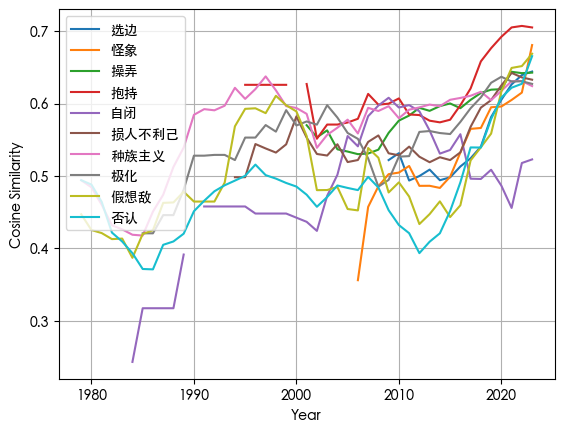

In [15]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/prejudice_cos-sim.csv')

# Specify the subset of words you want to plot
subset_words = ['选边', '怪象', '操弄', '抱持', '自闭', '损人不利己', '种族主义', '极化', '假想敌', '否认']

# Filter the dataframe for the subset of words
subset_df = df[['Year'] + subset_words]

# Plot the cosine similarity time-series for the subset of words
#for word in subset_words:
    #plt.plot(subset_df['Year'], subset_df[word], label=word)

# Apply moving average smoothing with window size of 5
smoothed_df = subset_df[subset_words].rolling(window=5, min_periods=1, center=True).mean()

# Plot the smoothed lines
for word in subset_words:
    plt.plot(subset_df['Year'], smoothed_df[word], label=f"{word}")

# Customize the plot
plt.rcParams['font.family'] = ['Heiti TC']
plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
# plt.title('Top 10 Words With the Highest Increased Similarity to "Terrorism" (Smoothed)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

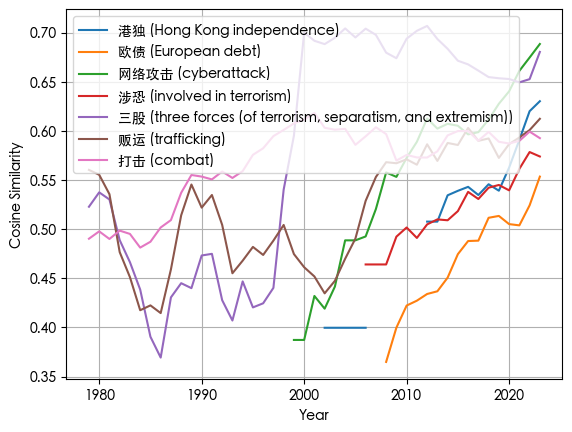

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

# Read the CSV file
df = pd.read_csv('/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/terrorism_cos-sim.csv')

# Specify the subset of words you want to plot
subset_words = ['港独', '欧债', '网络攻击', '涉恐', '三股', '贩运', '打击']
english = ['Hong Kong independence','European debt','cyberattack','involved in terrorism','three forces (of terrorism, separatism, and extremism)',
           'trafficking', 'combat']

subset_words_with_translation = [f"{chinese} ({eng})" for chinese, eng in zip(subset_words, english)]

# Filter the dataframe for the subset of words
subset_df = df[['Year'] + subset_words]

# Apply moving average smoothing with window size of 5
smoothed_df = subset_df[subset_words].rolling(window=5, min_periods=1, center=True).mean()

# Plot the smoothed lines
for word_with_translation in subset_words_with_translation:
    chinese_word = word_with_translation.split(' ')[0]
    plt.plot(subset_df['Year'], smoothed_df[chinese_word], label=word_with_translation)

# Customize the plot
plt.rcParams['font.family'] = ['Heiti TC']
plt.xlabel('Year')
plt.ylabel('Cosine Similarity')
# plt.title('Top 10 Words With the Highest Increased Similarity to "Terrorism" (Smoothed)')
plt.legend()
plt.grid(True)

# Display the plot
plt.show()

### Compare earliest and latest period

In [12]:
import json
from gensim.models import Word2Vec

model_folder = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi_raw/models/'
concepts_file = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/0_data/wordlist/concepts.json'
output_txt = '/Users/kawaiyuen/nlpworkshop/concept-creep-chi/2_pipeline/preprocessed/quali_cos-sim-time-series/topn-comparison/topn-comparison-earliest-latest_topn-10_full-lists.txt'

with open(concepts_file, 'r') as file:
    concepts = json.load(file)

# Create empty dictionaries to store the union of neighbors for each concept in each period
earliest_neighbors = {}
latest_neighbors = {}

for year in range(1979, 1984):
    # Load the word2vec model
    model = Word2Vec.load(model_folder + f'pd_{year}.model')

    # Iterate over each target concept
    for key, value in concepts.items():
        concept = value[0]

        # Check if the concept is present in the word2vec model's vocabulary
        if concept in model.wv.key_to_index:
            # Find the 10 most similar neighbor words for the concept
            neighbors = model.wv.most_similar(concept, topn=10)
            # Extract just the words from the word neighbors
            words = [word for word, _ in neighbors]

            # Update the earliest neighbors dictionary with the neighbors for the concept
            if concept not in earliest_neighbors:
                earliest_neighbors[concept] = set(words)
            else:
                earliest_neighbors[concept].update(words)

for year in range(2019, 2024):
    # Load the word2vec model
    model = Word2Vec.load(model_folder + f'pd_{year}.model')

    # Iterate over each target concept
    for key, value in concepts.items():
        concept = value[0]

        # Check if the concept is present in the word2vec model's vocabulary
        if concept in model.wv.key_to_index:
            # Find the 10 most similar neighbor words for the concept
            neighbors = model.wv.most_similar(concept, topn=10)
            # Extract just the words from the word neighbors
            words = [word for word, _ in neighbors]

            # Update the latest neighbors dictionary with the neighbors for the concept
            if concept not in latest_neighbors:
                latest_neighbors[concept] = set(words)
            else:
                latest_neighbors[concept].update(words)

# Create empty dictionaries to store the word neighbors that are present only in the earliest OR latest period
only_earliest = {}
only_latest = {}

# Find word neighbors that are present only in the earliest period
for concept, neighbors in earliest_neighbors.items():
    only_in_earliest = neighbors - latest_neighbors.get(concept, set())
    if only_in_earliest:
        only_earliest[concept] = only_in_earliest

# Find word neighbors that are present only in the latest period
for concept, neighbors in latest_neighbors.items():
    only_in_latest = neighbors - earliest_neighbors.get(concept, set())
    if only_in_latest:
        only_latest[concept] = only_in_latest

# Open the output TXT file in write mode
with open(output_txt, 'w') as file:
    # Write the earliest neighbors for each concept to the file
    file.write("Earliest Period (1979-1983):\n")
    for concept, neighbors in earliest_neighbors.items():
        # Mark the neighbors that appear in both the earliest and latest neighbor lists with an asterisk
        if concept in latest_neighbors:
            shared_neighbors = neighbors.intersection(latest_neighbors[concept])
            marked_neighbors = [f'{neighbor}*' if neighbor in shared_neighbors else neighbor for neighbor in neighbors]
            file.write(f'{concept} ({len(neighbors)}): {", ".join(marked_neighbors)}\n')
        else:
            file.write(f'{concept} ({len(neighbors)}): {", ".join(neighbors)}\n')

    # Write the latest neighbors for each concept to the file
    file.write("\nLatest Period (2019-2023):\n")
    for concept, neighbors in latest_neighbors.items():
        # Mark the neighbors that appear in both the earliest and latest neighbor lists with an asterisk
        if concept in earliest_neighbors:
            shared_neighbors = neighbors.intersection(earliest_neighbors[concept])
            marked_neighbors = [f'{neighbor}*' if neighbor in shared_neighbors else neighbor for neighbor in neighbors]
            file.write(f'{concept} ({len(neighbors)}): {", ".join(marked_neighbors)}\n')
        else:
            file.write(f'{concept} ({len(neighbors)}): {", ".join(neighbors)}\n')